[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/lymphoma-classification/blob/master/5_lymphoma_classification.ipynb)

# Lymphoma classification

## Data loading and preparation

In [1]:
import numpy as np
import pandas as pd

import os
import pickle

data_dir  = "./data"
data_file = "db_mediastinalbulky_v2-reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               119 non-null    float64
 1   lymphoma_type                    119 non-null    float64
 2   age                              111 non-null    float64
 3   SUVmin (SUV)                     111 non-null    float64
 4   SUVmean (SUV)                    111 non-null    float64
 5   MTV (# vx)                       111 non-null    float64
 6   SMTV (mL/Kg) TOT                 111 non-null    float64
 7   CONVENTIONAL_SUVbwmin            115 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       115 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       110 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  113 non-null    float64
 11  GLCM_Correlation                 113 non-null    float64
 12  GLRLM_SRE             

### Aggressive data cleaning 

In [2]:
data . dropna ( inplace = True )
data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               101 non-null    float64
 1   lymphoma_type                    101 non-null    float64
 2   age                              101 non-null    float64
 3   SUVmin (SUV)                     101 non-null    float64
 4   SUVmean (SUV)                    101 non-null    float64
 5   MTV (# vx)                       101 non-null    float64
 6   SMTV (mL/Kg) TOT                 101 non-null    float64
 7   CONVENTIONAL_SUVbwmin            101 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       101 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       101 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  101 non-null    float64
 11  GLCM_Correlation                 101 non-null    float64
 12  GLRLM_SRE             

### Splitting into train-set and test-set

In [3]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

no_gz = data.query ("lymphoma_type != 2")

X = no_gz[X_cols] . to_numpy()
y = no_gz[y_cols] . to_numpy() . flatten()
y = ( y == 3 )   # PML/Hodgkin classification

ratio = len(y[y == True]) / len(y[y == False])
print ( "PML-HL ratio on data-set : {:.1f}%" . format (100 * ratio) )

PML-HL ratio on data-set : 41.5%


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size = 0.2, random_state = 42 )

### Train-set
ratio_train = len(y_train[y_train == True]) / len(y_train[y_train == False])
print ( "PML-HL ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

### Test-set
ratio_test = len(y_test[y_test == True]) / len(y_test[y_test == False])
print ( "PML-HL ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

PML-HL ratio on train-set : 46.0%
PML-HL ratio on test-set  : 26.7%


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.2, random_state = 42 )
for idx_train, idx_test in sss . split ( X, y ):
  X_train , y_train = X[idx_train] , y[idx_train]
  X_test  , y_test  = X[idx_test]  , y[idx_test]

### Train-set
ratio_train = len(y_train[y_train == True]) / len(y_train[y_train == False])
print ( "PML-HL ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

### Test-set
ratio_test = len(y_test[y_test == True]) / len(y_test[y_test == False])
print ( "PML-HL ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

PML-HL ratio on train-set : 40.4%
PML-HL ratio on test-set  : 46.2%


### Data preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

#scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = QuantileTransformer (n_quantiles = 50, output_distribution = "normal")

X_train = scaler . fit_transform ( X_train )
X_test  = scaler . transform ( X_test )

np.mean (X_train, axis = 0)

array([ 9.12512075e-17, -3.04170692e-17,  1.79460708e-16, -5.32298710e-17,
       -2.56644021e-17, -1.87787381e-15,  6.84384056e-18,  1.10261876e-16,
        1.25622496e-15,  1.00072158e-15,  5.11006762e-16,  1.09501449e-16,
        3.75650804e-16, -4.18234701e-17,  6.31154185e-17, -4.25838968e-17,
       -9.42929144e-17])

## Dummy Classifier

In [7]:
from utils import DummyClassifier

clf_dummy = DummyClassifier()

In [8]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score ( clf_dummy, X_train, y_train, scoring = "accuracy", cv = 3 )

from utils import display_score
display_score ( scores = scores, score_name = "accuracy", model_name = "Dummy Classifier" )

+--------------------+
|  Dummy Classifier  |
+--------------------+
| accuracy : [0.48       0.625      0.58333333]
| mean : 56.3%
| std  : 6.1%
+--- - -


+---->  Label HL   <----+
|   Precision : 74.1%   |
|   Recall    : 82.7%   |
+---->  Label PML  <----+
|   Precision : 40.0%   |
|   Recall    : 28.6%   |
+-----------------------+


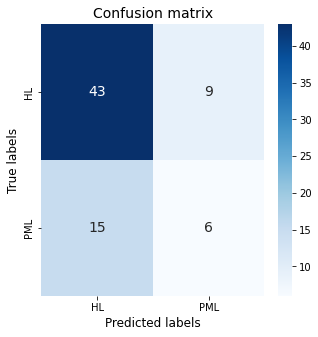

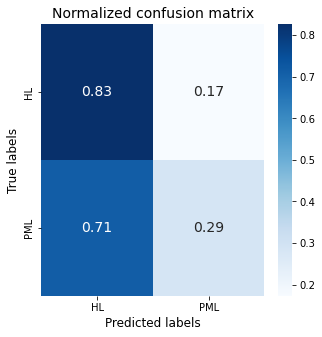

In [9]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict ( clf_dummy, X_train, y_train, cv = 3 )

from utils import precision_recall_scores
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )


## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression ( 
                                    penalty = "l2" ,
                                    class_weight = "balanced" ,
                                    solver = "liblinear" ,
                                    max_iter = 500 ,
                                    multi_class = "ovr" ,
                                  )

y_scores = cross_val_predict ( clf_logistic, X_train, y_train, cv = 3, method = "decision_function" )
#y_scores

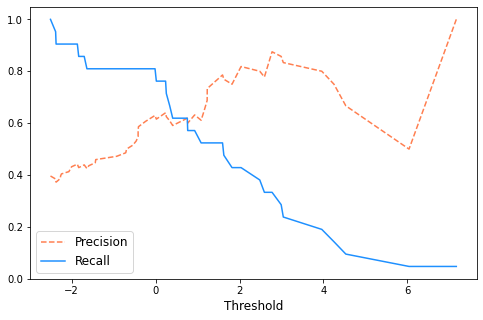

+---->  Label HL   <----+
|   Precision : 93.3%   |
|   Recall    : 53.8%   |
+---->  Label PML  <----+
|   Precision : 44.2%   |
|   Recall    : 90.5%   |
+-----------------------+


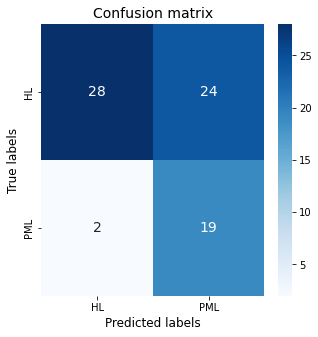

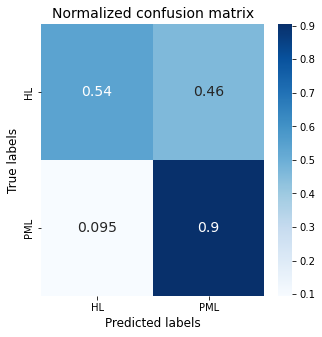

In [37]:
from utils import custom_predictions

y_train_pred_90 = custom_predictions (y_train, y_scores, recall_score = 0.9, show_curves = True)
_ = precision_recall_scores ( y_train, y_train_pred_90, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

+---->  Label HL   <----+
|   Precision : 91.3%   |
|   Recall    : 80.8%   |
+---->  Label PML  <----+
|   Precision : 63.0%   |
|   Recall    : 81.0%   |
+-----------------------+


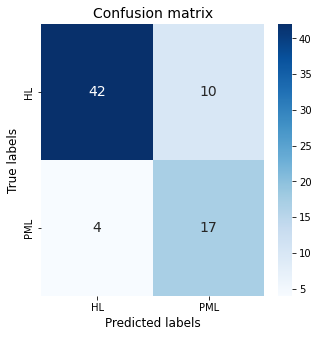

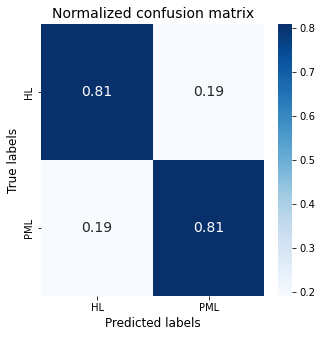

In [38]:
y_train_pred_80 = custom_predictions (y_train, y_scores, recall_score = 0.8)
_ = precision_recall_scores ( y_train, y_train_pred_80, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

+---->  Label HL   <----+
|   Precision : 87.8%   |
|   Recall    : 82.7%   |
+---->  Label PML  <----+
|   Precision : 62.5%   |
|   Recall    : 71.4%   |
+-----------------------+


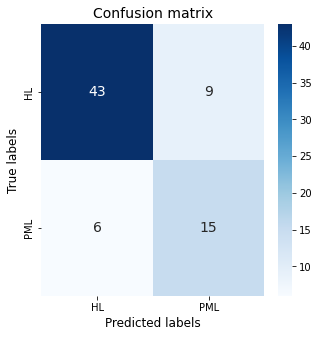

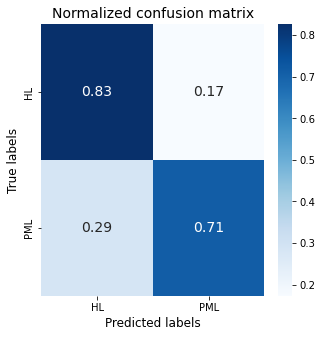

In [39]:
y_train_pred_70 = custom_predictions (y_train, y_scores, recall_score = 0.7)
_ = precision_recall_scores ( y_train, y_train_pred_70, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

### Automatic hyperparameters tuning

In [14]:
import optuna
optuna.logging.set_verbosity ( optuna.logging.ERROR )   # silence Optuna during trials study

### Return a set of trials studied by Optuna
def optuna_study (
                   model_name  : str ,
                   storage_dir : str ,
                   objective   : float ,
                   n_trials    : int = 10 ,
                   direction : str = "minimize"  , 
                   load_if_exists : bool = False ,
                 ):
  storage_path = "{}/{}.db" . format (storage_dir, model_name)
  storage_name = "sqlite:///{}" . format (storage_path)  

  if load_if_exists:
    pass
  elif not ( load_if_exists ) and os.path.isfile ( storage_path ):
    os.remove ( storage_path )

  study = optuna.create_study ( 
                                study_name = model_name ,
                                storage  = storage_name ,
                                load_if_exists = load_if_exists ,
                                direction = direction
                              )

  study . optimize ( objective, n_trials = n_trials )

  return study

In [15]:
from sklearn.metrics import roc_auc_score

def obj_logistic (trial):
  C = trial . suggest_float ( "C", 1e-3, 1e1, log = True )
  c_weights = trial . suggest_categorical ( "c_weights" , [None, "balanced"] )
  solver    = trial . suggest_categorical ( "solver", ["lbfgs", "liblinear"] )
  max_iter  = trial . suggest_int ( "max_iter", 200, 1000, log = True )

  model = LogisticRegression ( 
                               penalty = "l2" ,
                               C = C ,
                               class_weight = c_weights ,
                               solver = solver ,
                               max_iter = max_iter ,
                               multi_class = "ovr" ,
                             )
  
  y_scores = cross_val_predict ( model, X_train, y_train, cv = 3, method = "decision_function" )
  return roc_auc_score ( y_train, y_scores )


study_logistic = optuna_study (
                                model_name  = "clf_logistic"  ,
                                storage_dir = "./storage" ,
                                objective = obj_logistic ,
                                n_trials  = 50 ,
                                direction = "maximize" ,
                                load_if_exists = False ,
                              )

In [16]:
df = study_logistic . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_C,params_c_weights,params_max_iter,params_solver,value
31,0.001013,None,309,liblinear,0.894689
26,0.001015,None,565,liblinear,0.894689
46,0.001105,None,429,liblinear,0.894689
23,0.001064,None,478,liblinear,0.894689
39,0.001014,None,355,liblinear,0.894689


In [40]:
best_params = study_logistic . best_params

clf_logistic = LogisticRegression ( 
                                    penalty = "l2" ,
                                    C = best_params["C"] ,
                                    class_weight = best_params["c_weights"] ,
                                    solver = best_params["solver"] ,
                                    max_iter = best_params["max_iter"] ,
                                    multi_class = "ovr" ,
                                  )

y_scores = cross_val_predict ( clf_logistic, X_train, y_train, cv = 3, method = "decision_function" )

+---->  Label HL   <----+
|   Precision : 97.4%   |
|   Recall    : 71.2%   |
+---->  Label PML  <----+
|   Precision : 57.1%   |
|   Recall    : 95.2%   |
+-----------------------+


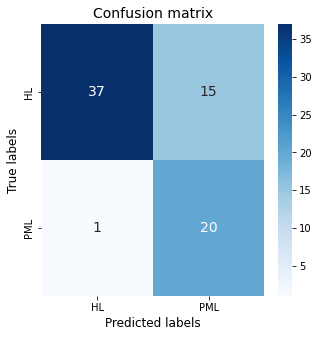

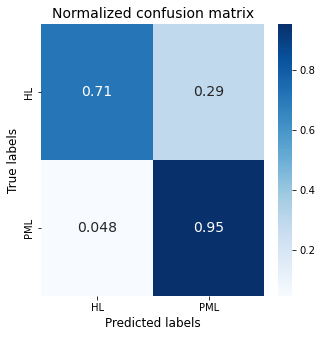

In [41]:
y_train_pred_95 = custom_predictions (y_train, y_scores, recall_score = 0.95)
_ = precision_recall_scores ( y_train, y_train_pred_95, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

+---->  Label HL   <----+
|   Precision : 95.3%   |
|   Recall    : 78.8%   |
+---->  Label PML  <----+
|   Precision : 63.3%   |
|   Recall    : 90.5%   |
+-----------------------+


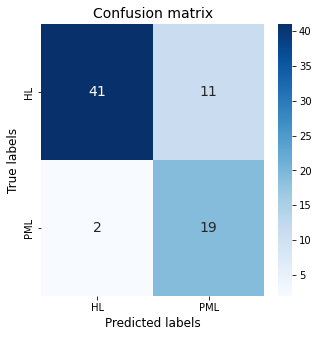

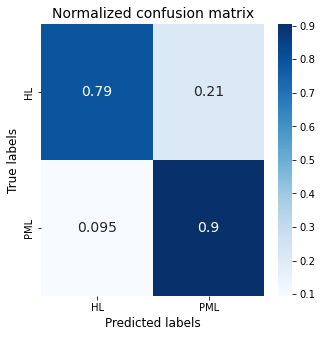

In [42]:
y_train_pred_90 = custom_predictions (y_train, y_scores, recall_score = 0.90)
_ = precision_recall_scores ( y_train, y_train_pred_90, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

+---->  Label HL   <----+
|   Precision : 93.2%   |
|   Recall    : 78.8%   |
+---->  Label PML  <----+
|   Precision : 62.1%   |
|   Recall    : 85.7%   |
+-----------------------+


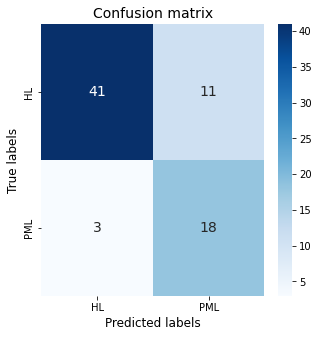

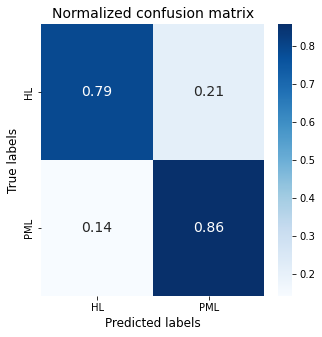

In [43]:
y_train_pred_85 = custom_predictions (y_train, y_scores, recall_score = 0.85)
_ = precision_recall_scores ( y_train, y_train_pred_85, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

### Features ranking

In [21]:
from sklearn.feature_selection import RFECV

selector = RFECV ( clf_logistic, step = 1, cv = 3 )
selector . fit ( X_train, y_train )

RFECV(cv=3,
      estimator=LogisticRegression(C=0.0010896946369757432, max_iter=297,
                                   multi_class='ovr', solver='liblinear'))

In [22]:
ranks = selector . ranking_
print ( "+-------------------+" )
print ( "|  Ranked Features  |" )
print ( "+-------------------+" )
for rnk, feat in zip (ranks, X_cols):
  print ( "| Rank-{:02} : {}" . format (rnk, feat) )
print ( "+--- - -" )

high_ranked_feats = np.argsort (ranks) [:5]
X_train_hrf = X_train [:,high_ranked_feats]
X_test_hrf  = X_test  [:,high_ranked_feats]

+-------------------+
|  Ranked Features  |
+-------------------+
| Rank-16 : age
| Rank-15 : SUVmin (SUV)
| Rank-01 : SUVmean (SUV)
| Rank-04 : MTV (# vx)
| Rank-17 : SMTV (mL/Kg) TOT
| Rank-13 : CONVENTIONAL_SUVbwmin
| Rank-09 : CONVENTIONAL_SUVbwKurtosis
| Rank-07 : DISCRETIZED_HISTO_Kurtosis
| Rank-08 : SHAPE_Sphericity[onlyFor3DROI])
| Rank-05 : GLCM_Correlation
| Rank-03 : GLRLM_SRE
| Rank-06 : NGLDM_Coarseness
| Rank-14 : NGLDM_Busyness
| Rank-10 : GLZLM_LZE
| Rank-11 : GLZLM_LZLGE
| Rank-12 : GLZLM_LZHGE
| Rank-02 : GLZLM_ZLNU
+--- - -


## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier (
                                      n_estimators = 100 ,
                                      criterion = "gini" ,
                                      max_features = "sqrt" ,
                                      max_leaf_nodes = 10 ,
                                      max_depth = 5 ,
                                      class_weight = "balanced" ,
                                    )

y_scores = cross_val_predict ( clf_forest, X_train, y_train, cv = 3, method = "predict_proba" )

from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve (y_train, y_scores[:,0])
threshold

array([0.11      , 0.14210526, 0.15007611, 0.15112666, 0.17674232,
       0.18285714, 0.19266481, 0.22074074, 0.23942719, 0.25335488,
       0.25901444, 0.34580404, 0.36686205, 0.41074074, 0.45      ,
       0.473028  , 0.4889197 , 0.51      , 0.53074074, 0.5349966 ,
       0.54060729, 0.57769499, 0.6264702 , 0.65550053, 0.66298559,
       0.67717085, 0.68394879, 0.69117647, 0.74      , 0.75007827,
       0.76476412, 0.78      , 0.79      , 0.79040462, 0.81703688,
       0.83551129, 0.84583333, 0.85285714, 0.85583333, 0.85993315,
       0.86613866, 0.87      , 0.87337871, 0.87778361, 0.88074074,
       0.88285714, 0.89      , 0.90520663, 0.91      , 0.91528519,
       0.92      , 0.92314031, 0.92615385, 0.93      , 0.93660714,
       0.94901099, 0.95      , 0.95033175, 0.95285714, 0.95375   ,
       0.96615385, 0.96901099, 0.97      , 0.98      , 0.99      ,
       1.        ])

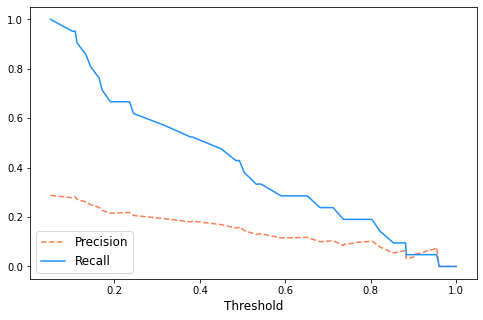

+---->  Label HL   <----+
|   Precision : 20.0%   |
|   Recall    : 1.9%   |
+---->  Label PML  <----+
|   Precision : 25.0%   |
|   Recall    : 81.0%   |
+-----------------------+


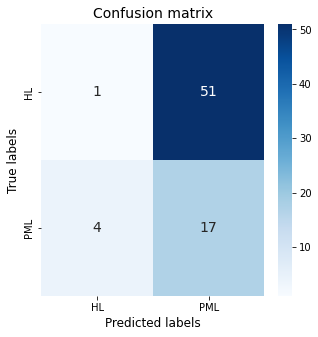

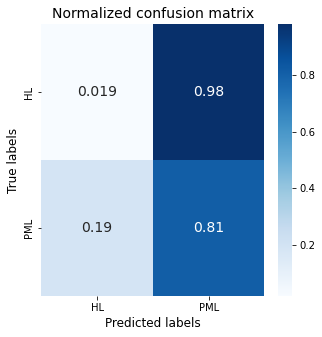

In [29]:
y_train_pred_90 = custom_predictions (y_train, y_scores, recall_score = 0.80, show_curves = True)
_ = precision_recall_scores ( y_train, y_train_pred_90, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

+---->  Label HL   <----+
|   Precision : 20.0%   |
|   Recall    : 3.8%   |
+---->  Label PML  <----+
|   Precision : 20.6%   |
|   Recall    : 61.9%   |
+-----------------------+


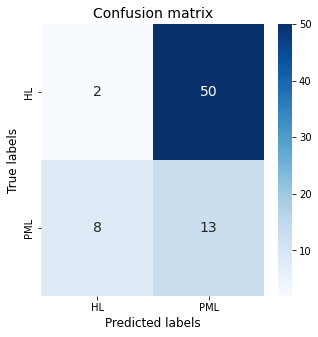

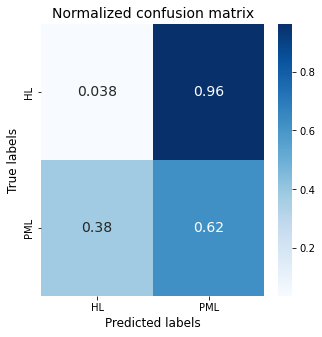

In [30]:
y_train_pred_80 = custom_predictions (y_train, y_scores, recall_score = 0.60)
_ = precision_recall_scores ( y_train, y_train_pred_80, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

+---->  Label HL   <----+
|   Precision : 29.4%   |
|   Recall    : 9.6%   |
+---->  Label PML  <----+
|   Precision : 16.1%   |
|   Recall    : 42.9%   |
+-----------------------+


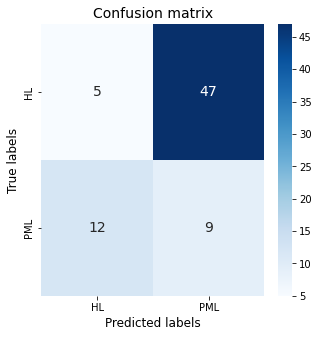

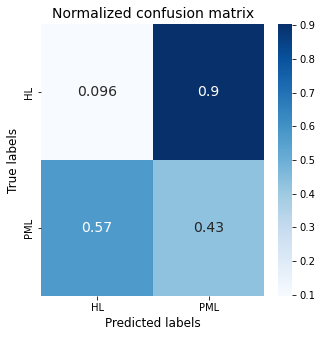

In [31]:
y_train_pred_70 = custom_predictions (y_train, y_scores, recall_score = 0.40)
_ = precision_recall_scores ( y_train, y_train_pred_70, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True )

### Automatic hyperparameters tuning

In [61]:
def obj_forest (trial):
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["gini", "entropy"] )
  max_feats = trial . suggest_categorical ( "max_feats", ["sqrt", "log2", None] )
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )
  c_weights = trial . suggest_categorical ( "c_weights", ["balanced", "balanced_subsample", None] )

  model = RandomForestClassifier ( 
                                   n_estimators = n_estims ,
                                   criterion = criterion   ,
                                   max_features = max_feats  ,
                                   max_leaf_nodes = max_leaf ,
                                   max_depth = max_depth ,
                                   class_weight = c_weights ,
                                 )
  
  y_scores = cross_val_predict ( model, X_train, y_train, cv = 3, method = "decision_function" )
  return roc_auc_score ( y_train, y_scores )


study_forest = optuna_study (
                              model_name  = "clf_forest"  ,
                              storage_dir = "./storage" ,
                              objective = obj_forest ,
                              n_trials  = 50 ,
                              direction = "maximize" ,
                              load_if_exists = False ,
                            )

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [62]:
df = study_forest . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

NameError: name 'study_forest' is not defined

+----------------------------+
|  Random Forest Classifier  |
+----------------------------+
| Accuracy : [0.92592593 0.77777778 0.69230769]
| Mean : 79.9%
| Std  : 9.7%
+--- - -
+---->  Label NHL  <----+
|   Precision : 66.7%   |
|   Recall    : 75.9%   |
+---->  Label HL   <----+
|   Precision : 85.1%   |
|   Recall    : 78.4%   |
+-----------------------+


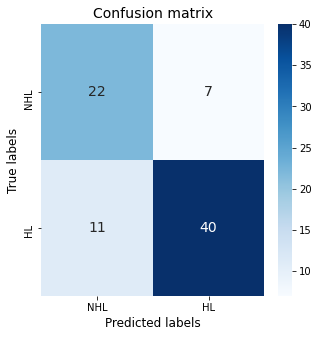

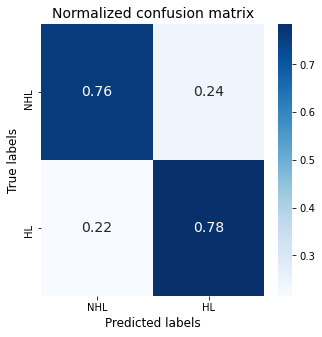

In [ ]:
best_params = study_forest . best_params

clf_forest = RandomForestClassifier (
                                      n_estimators = best_params["n_estims"] ,
                                      criterion = best_params["criterion"]   ,
                                      max_features = best_params["max_feats"]  ,
                                      max_leaf_nodes = best_params["max_leaf"] ,
                                      max_depth = best_params["max_depth"] ,
                                      class_weight = best_params["c_weights"] ,
                                    )

scores = cross_val_score ( clf_forest, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_forest, X_train, y_train, cv = 3 )

display_score ( model_name = "Random Forest Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

## Gradient Boosted Decision Trees

+-------------------+
|  GBDT Classifier  |
+-------------------+
| Accuracy : [0.74074074 0.74074074 0.65384615]
| Mean : 71.2%
| Std  : 4.1%
+--- - -
+---->  Label NHL  <----+
|   Precision : 55.2%   |
|   Recall    : 55.2%   |
+---->  Label HL   <----+
|   Precision : 74.5%   |
|   Recall    : 74.5%   |
+-----------------------+


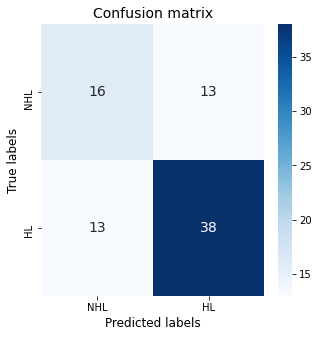

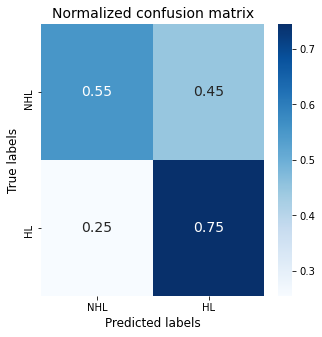

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbdt = GradientBoostingClassifier (
                                        loss = "deviance" ,
                                        learning_rate = 0.3 ,
                                        n_estimators  = 100 ,
                                        criterion = "friedman_mse" ,
                                        max_features  = None , 
                                        max_leaf_nodes = 10 ,
                                        max_depth = 5       ,
                                      )

scores = cross_val_score ( clf_gbdt, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3 )

display_score ( model_name = "GBDT Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

### Automatic hyperparameters tuning

In [ ]:
def obj_gbdt (trial):
  loss = trial . suggest_categorical ( "loss", ["deviance", "exponential"] )
  lr   = trial . suggest_float ( "lr", 0.05, 0.95, log = True )
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["friedman_mse", "mse"] )
  max_feats = trial . suggest_categorical ( "max_feats", ["sqrt", "log2", None] )
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )

  model = GradientBoostingClassifier ( 
                                       loss = loss ,
                                       learning_rate =  lr , 
                                       n_estimators  =  n_estims , 
                                       criterion  =  criterion   ,
                                       max_features  = max_feats , 
                                       max_leaf_nodes = max_leaf ,
                                       max_depth = max_depth ,
                                     )
  
  y_pred  = cross_val_predict ( model, X_train_hrf, y_train, cv = 3 )
  precision, recall = precision_recall_scores ( y_train, y_pred )

  weights = np.array ( [ ratio_train, 1. ] )
  scores  = recall
  
  return np.sum ( scores / weights ) / np.sum ( 1 / weights )


study_gbdt = optuna_study (
                          model_name  = "clf_gbdt"  ,
                          storage_dir = "./storage" ,
                          objective = obj_gbdt ,
                          n_trials  = 50 ,
                          direction = "maximize" ,
                          load_if_exists = False ,
                        )

In [ ]:
df = study_gbdt . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_criterion,params_loss,params_lr,params_max_depth,params_max_feats,params_max_leaf,params_n_estims,value
31,mse,exponential,0.111925,4,sqrt,14,228,0.731736
11,mse,exponential,0.054177,3,sqrt,14,179,0.716861
18,mse,exponential,0.115118,4,None,13,199,0.716861
4,mse,exponential,0.122640,6,None,2,171,0.701986
14,mse,exponential,0.090327,4,sqrt,16,98,0.701986


+-------------------+
|  GBDT Classifier  |
+-------------------+
| Accuracy : [0.81481481 0.62962963 0.69230769]
| Mean : 71.2%
| Std  : 7.7%
+--- - -
+---->  Label NHL  <----+
|   Precision : 62.5%   |
|   Recall    : 51.7%   |
+---->  Label HL   <----+
|   Precision : 75.0%   |
|   Recall    : 82.4%   |
+-----------------------+


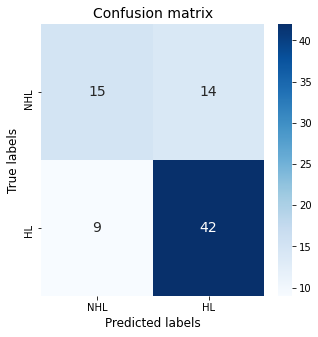

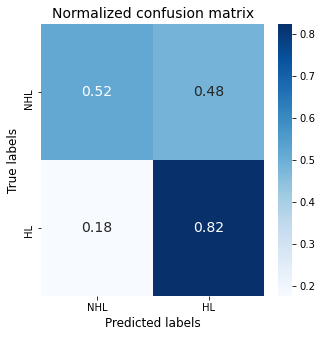

In [ ]:
best_params = study_gbdt . best_params

clf_gbdt = GradientBoostingClassifier (
                                        loss = best_params["loss"] ,
                                        learning_rate = best_params["lr"] ,
                                        n_estimators  = best_params["n_estims"]  ,
                                        criterion  =  best_params["criterion"]   ,
                                        max_features  = best_params["max_feats"] ,
                                        max_leaf_nodes = best_params["max_leaf"] ,
                                        max_depth = best_params["max_depth"] ,
                                      )

scores = cross_val_score ( clf_gbdt, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3 )

display_score ( model_name = "GBDT Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

## Models combination

+----------------------+
|  Models combination  |
+----------------------+
| Accuracy : [0.92592593 0.77777778 0.69230769]
| Mean : 79.9%
| Std  : 9.7%
+--- - -
+---->  Label NHL  <----+
|   Precision : 68.8%   |
|   Recall    : 75.9%   |
+---->  Label HL   <----+
|   Precision : 85.4%   |
|   Recall    : 80.4%   |
+-----------------------+


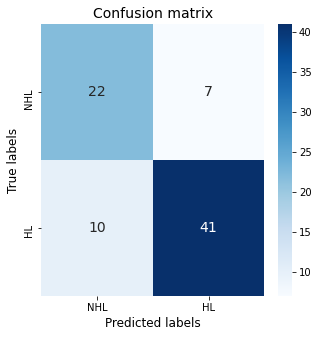

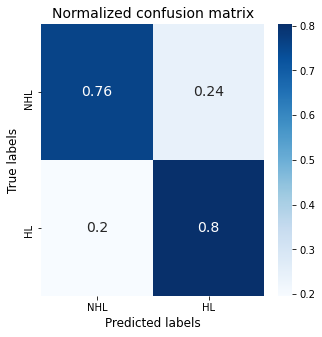

In [ ]:
from sklearn.ensemble import VotingClassifier

clf_ens = VotingClassifier (
                             estimators = [ ("logistic", clf_logistic), ("forest", clf_forest), ("GBDT", clf_gbdt) ],
                             voting = "hard"
                           )

scores = cross_val_score ( clf_ens, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_ens, X_train_hrf, y_train, cv = 3 )

display_score ( model_name = "Models combination", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

## Model evaluation

+---->  Label NHL  <----+
|   Precision : 83.3%   |
|   Recall    : 71.4%   |
+---->  Label HL   <----+
|   Precision : 86.7%   |
|   Recall    : 92.9%   |
+-----------------------+


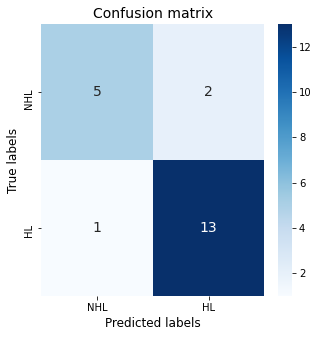

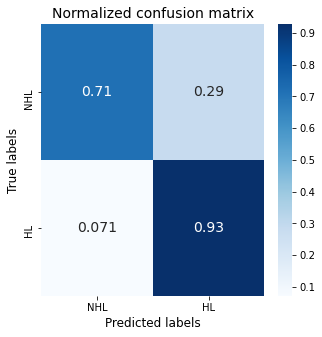

In [ ]:
model = clf_ens . fit ( X_train_hrf, y_train )

y_test_pred = model . predict ( X_test_hrf )

_ = precision_recall_scores ( y_test, y_test_pred, verbose = True, labels = ["NHL", "HL"], show_conf_matrix = True )

## Model export

In [ ]:
model_dir = "./models"
exp_model_file = "binary_classifier_v1.pkl"
exp_model_path = os.path.join ( model_dir, exp_model_file )

pickle . dump ( model, open ( exp_model_path, "wb" ) )